1. Monthly vol data  already preprocessed
2. Poc attributes - already prepoc
3. PPg attribues- already preproc
4. Macro economic - raw-> year-monthly-> wide format ( date + features...)
5. Financial at PPg - year-month-ppg-features
6. Weather data - Daily-> monthly agg
7. Covid- Daily -> monthly 
8. Calendar Custom features

In [1]:
# import jupyter_black

# jupyter_black.load()

In [2]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [3]:
import os

os.chdir(
    r"/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
from pandarallel import pandarallel
import re
from datetime import datetime
import gc
from sklearn.preprocessing import FunctionTransformer

# from helpers.compress import reduce_mem_usage
import pickle
import warnings

warnings.filterwarnings("ignore")

In [5]:
pandarallel.initialize(progress_bar=True, nb_workers=os.cpu_count() - 2)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
data_folder = "data"
macro_data_folder = "macro_data"
processed_data_folder = "processed_data_S2"

In [7]:
# volume_agg_df = pd.read_pickle(
#     os.path.join(os.getcwd(), processed_data_folder, "volume_df_month_agg.pkl")
# )

##### Attributes

In [8]:
poc_atrb_df = pd.read_csv(
    os.path.join(os.getcwd(), data_folder, "hackathon_poc_description_data.csv")
)
ppg_atrb_df = pd.read_csv(
    os.path.join(os.getcwd(), data_folder, "hackathon_product_description_data.csv")
)

In [9]:
poc_atrb_df.head()

,unique_poc_id,region,subchannel,channel_type,sales_district,segment
0,A,ALKP,AFMJ ZQQ,KVF,TGG BIRO AFDC ADCB,AHJB ZQQ
1,AA,ALKP,AFMJ ZQQ,KVF,TGG BIRO JIE,AHJB ZQQ
2,AAA,ALKP,FUK AIMO BGGD AGHI,BBOB,TGG BIRO ABNS,AKWM
3,AAAA,ALKP,ADDS ZQQ,KVF,TGG BIRO ABEP,AHJB ZQQ
4,AAAC,AZAK AHZ,AQXZ APPZ ADOT,BBOB,VOP BIRO ABXN,AZJC UIP


In [10]:
poc_atrb_df.shape, poc_atrb_df.isnull().sum()

((43645, 6),
 unique_poc_id     1
 region            0
 subchannel        0
 channel_type      0
 sales_district    0
 segment           0
 dtype: int64)

In [11]:
poc_atrb_df["unique_poc_id"] = poc_atrb_df["unique_poc_id"].fillna("NA1")

In [12]:
ppg_atrb_df.head()

,Unnamed: 0,ppg_name,brand,subbrand,pack_type,pack_volume,category_name,price_segment
0,0,BN EQ BL FP FN D,BN EQ,BN EQ BL FP,FN,D,FT BM,FG
1,1,FA FN DY,FA,FA,FN,DY,BM,CW
2,2,DE AI BH ES DX,FD CL CO,DE AI BH,ES,DX,BM,EJ CW
3,3,CM ES T,CM,CM,ES,T,BM,CW
4,4,AK BK CG T,AK,AK BK,CG,T,FT BM,BR


In [13]:
ppg_atrb_df = ppg_atrb_df.drop(["Unnamed: 0"], axis=1)

In [14]:
ppg_atrb_df.shape, ppg_atrb_df.isnull().sum()

((240, 7),
 ppg_name         0
 brand            0
 subbrand         0
 pack_type        0
 pack_volume      0
 category_name    0
 price_segment    0
 dtype: int64)

In [15]:
ppg_atrb_df.drop_duplicates(['ppg_name']).shape

(240, 7)

In [16]:
poc_atrb_df.drop_duplicates(['unique_poc_id']).shape

(43645, 6)

##### Macro

In [17]:
macro_eco_df = pd.read_csv(
    os.path.join(os.getcwd(), macro_data_folder, "MACROECONOMICS DATA.csv")
)

In [18]:
macro_eco_df = macro_eco_df.loc[
    macro_eco_df["frequency"] == "monthly", ["date", "concept", "value", "unit"]
].reset_index(drop=True)

In [19]:
macro_eco_df["date"] = pd.to_datetime(
    macro_eco_df["date"], yearfirst=True, errors="coerce"
)

In [20]:
macro_eco_df_pvt = pd.pivot_table(
    data=macro_eco_df,
    index=["date"],
    columns=["concept"],
    values=["value"],
    fill_value=0.0,
)

macro_eco_df_pvt.columns = macro_eco_df_pvt.columns.get_level_values(1)
macro_eco_df_pvt.columns.name = ""

macro_eco_df_pvt = macro_eco_df_pvt.reset_index(drop=False)

macro_eco_df_pvt["year"] = macro_eco_df_pvt["date"].dt.year
macro_eco_df_pvt["month"] = macro_eco_df_pvt["date"].dt.month

In [21]:
macro_eco_df_pvt.head()

,date,central bank policy rate,"consumer price index, aop","consumer price index, aop, usd","effective exchange rate index, nominal","exchange rate lc per eur, aop","exchange rate lc per eur, eop","exchange rate lc per usd, aop","exchange rate lc per usd, eop","exchange rate lc per yen, aop","exchange rate lc per yen, eop","exchange rate usd per lc, aop","exchange rate usd per lc, eop","inflation, cpi, aop","inflation, cpi, aop, usd","inflation, wpi, aop","inflation, wpi, aop, usd","interest rate, long-term","interest rate, long-term, differential with the usa","interest rate, short-term","interest rate, short-term, differential with the usa","interest rate, short-term, real","production index, industry","production index, industry, % change previous year",real fx index,"retail sales, value index","retail sales, value index, usd","retail sales, volume index","retail sales, volume index, % change previous year",spread of long over short interest rate,wholesale price index,"wholesale price index, usd",year,month
0,2019-01-01,6.75,97.807319,101.882102,102.468635,15.831213,15.307645,13.867566,13.32490,0.127279,0.122337,0.072111,0.075047,3.962645,-8.532567,4.055963,-8.450465,9.3,6.59,7.39,5.02,3.296718,100.650325,0.499500,95.949289,96.086273,100.111209,98.250239,1.348131,1.91,97.438908,101.497904,2019,1
1,2019-02-01,6.75,98.162100,102.595856,102.849898,15.688265,15.928973,13.821043,13.95320,0.125240,0.125829,0.072353,0.071668,4.044073,-10.873784,4.800473,-10.225838,9.3,6.62,7.13,4.74,2.965980,100.450225,0.601202,95.627395,96.794315,101.188380,98.616510,1.219668,2.17,97.738142,102.152306,2019,2
2,2019-03-01,6.75,98.802462,99.207368,99.065731,16.259453,16.275976,14.386350,14.48685,0.129367,0.130606,0.069510,0.069028,4.609073,-14.002354,6.189641,-12.702991,9.2,6.63,6.98,4.58,2.266464,100.350175,0.905433,99.538742,97.961332,98.384268,99.158634,1.086230,2.22,98.661848,99.065748,2019,3
3,2019-04-01,6.75,99.297142,101.405621,101.090324,15.896098,16.036355,14.144953,14.29520,0.126677,0.127979,0.070697,0.069954,4.395847,-10.611090,6.532126,-8.781903,9.1,6.57,7.23,4.85,2.714813,103.951976,6.673511,97.868521,98.748308,100.867152,99.457270,2.056462,1.87,99.879266,101.999664,2019,4
4,2019-05-01,6.75,99.821805,99.934308,100.068526,16.138887,16.369333,14.429045,14.67970,0.131372,0.134270,0.069305,0.068121,4.601734,-9.078773,6.508732,-7.421185,9.1,6.70,7.13,4.78,2.417040,102.151076,1.089109,99.834147,98.875408,99.008458,99.061863,1.342332,1.97,100.496904,100.609733,2019,5


In [22]:
macro_eco_df_pvt.shape, macro_eco_df_pvt.isnull().sum()

((73, 34),
 
 date                                                    0
 central bank policy rate                                0
 consumer price index, aop                               0
 consumer price index, aop, usd                          0
 effective exchange rate index, nominal                  0
 exchange rate lc per eur, aop                           0
 exchange rate lc per eur, eop                           0
 exchange rate lc per usd, aop                           0
 exchange rate lc per usd, eop                           0
 exchange rate lc per yen, aop                           0
 exchange rate lc per yen, eop                           0
 exchange rate usd per lc, aop                           0
 exchange rate usd per lc, eop                           0
 inflation, cpi, aop                                     0
 inflation, cpi, aop, usd                                0
 inflation, wpi, aop                                     0
 inflation, wpi, aop, usd                  

In [75]:
macro_eco_df_pvt.drop_duplicates(['year','month']).shape

(73, 34)

##### PPG financials

In [23]:
ppg_financials = pd.read_csv(
    os.path.join(os.getcwd(), macro_data_folder, "FINANCIALS DATA.csv")
)

In [24]:
ppg_financials.head()

,year,month,maco_hl,nr_hl,ppg_name
0,2023,2,47.179571,116.526880,GD A ES B
1,2023,12,47.073232,117.612651,GH GE FN DX
2,2024,3,0.000000,0.000000,EF FC EN FO
3,2024,3,0.000000,0.000000,DZ E BW AB ES EH
4,2021,12,51.676846,107.904104,CJ CZ ES ER


In [25]:
ppg_financials.shape, ppg_financials.isnull().sum()

((8694, 5),
 year        0
 month       0
 maco_hl     0
 nr_hl       0
 ppg_name    0
 dtype: int64)

In [26]:
missed_fin_ppg = list(
    set(ppg_atrb_df["ppg_name"].unique()).difference(set(ppg_financials["ppg_name"]))
)

In [27]:
len(missed_fin_ppg)

36

In [28]:
ppg_financials = ppg_financials.groupby(
    ["ppg_name", "year", "month"], as_index=False
).agg({"maco_hl": "mean", "nr_hl": "mean"})

In [29]:
ppg_financials.shape

(8568, 5)

##### Calendar

In [30]:
calendar_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "calendar.pkl")
)

In [31]:
calendar_df.head(3)

,date,year,month,week,adjusted_year,adjusted_month,year_week_start_date,day_of_the_week,is_weekend,is_month_start,is_month_end,quarter,key,holiday,month_sin_adj,month_cos_adj,month_sin,month_cos,week_sin,week_cos,quarter_sin,quarter_cos,year_month_start_date
0,2019-01-01,2019,1,1,2019,1,2019-01-01,1,0,1,0,1,1,1.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
1,2019-01-02,2019,1,1,2019,1,2019-01-01,2,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01
2,2019-01-03,2019,1,1,2019,1,2019-01-01,3,0,0,0,1,1,0.0,0.5,0.866025,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17,2019-01-01


In [32]:
calendar_df_week = calendar_df.loc[
    :,
    [
        "date",
        "week",
        "adjusted_year",
        "year_week_start_date",
        "is_month_start",
        "is_month_end",
        "quarter",
        "holiday",
        "month_sin_adj",
        "month_cos_adj",
        "week_sin",
        "week_cos",
        "quarter_sin",
        "quarter_cos",
    ],
]

In [33]:
calendar_df_week = (
    calendar_df_week.groupby(["adjusted_year", "week"])
    .agg(
        {
            "year_week_start_date": "max",
            "is_month_start": "max",
            "is_month_end": "max",
            "holiday": "sum",
            "month_sin_adj": "max",
            "month_cos_adj": "max",
            "week_sin": "max",
            "week_cos": "max",
            "quarter_sin": "max",
            "quarter_cos": "max",
        }
    )
    .reset_index(drop=False)
)

In [34]:
calendar_df_week.head(3)

,adjusted_year,week,year_week_start_date,is_month_start,is_month_end,holiday,month_sin_adj,month_cos_adj,week_sin,week_cos,quarter_sin,quarter_cos
0,2019,1,2019-01-01,1,0,1.0,0.5,0.866025,0.120537,0.992709,1.0,6.123234e-17
1,2019,2,2019-01-07,0,0,0.0,0.5,0.866025,0.239316,0.970942,1.0,6.123234e-17
2,2019,3,2019-01-14,0,0,0.0,0.5,0.866025,0.354605,0.935016,1.0,6.123234e-17


In [35]:
calendar_df_month = calendar_df.loc[
    :,
    [
        "date",
        "year",
        "month",
        "quarter",
        "holiday",
        "month_sin",
        "month_cos",
        "quarter_sin",
        "quarter_cos",
        "year_month_start_date",
    ],
]

In [36]:
calendar_df_month = calendar_df_month.groupby(
    ["year", "month", "quarter"], as_index=False
).agg(
    {
        "year_month_start_date": "max",
        "holiday": "sum",
        "month_sin": "max",
        "month_cos": "max",
        "quarter_sin": "max",
        "quarter_cos": "max",
    }
)

In [37]:
calendar_df_month.head(3)

,year,month,quarter,year_month_start_date,holiday,month_sin,month_cos,quarter_sin,quarter_cos
0,2019,1,1,2019-01-01,1.0,0.500000,8.660254e-01,1.0,6.123234e-17
1,2019,2,1,2019-02-01,0.0,0.866025,5.000000e-01,1.0,6.123234e-17
2,2019,3,1,2019-03-01,1.0,1.000000,6.123234e-17,1.0,6.123234e-17


In [39]:
print(calendar_df_month.drop_duplicates(['year','month']).shape)
print(calendar_df_month.shape)

(60, 9)
(60, 9)


##### Weather 

In [40]:
weather_data = pd.read_csv(
    os.path.join(os.getcwd(), macro_data_folder, "sa_weather_data.csv")
)

In [41]:
weather_data = weather_data.drop(
    ["Unnamed: 0", "name", "feelslikemax", "feelslikemin", "feelslike"], axis=1
)

In [42]:
weather_data.shape, weather_data.isnull().sum()

((1826, 8),
 date        0
 tempmax     0
 tempmin     0
 temp        0
 dew         0
 humidity    0
 precip      0
 windgust    0
 dtype: int64)

In [43]:
weather_data["date"] = pd.to_datetime(weather_data["date"], errors="coerce")

In [44]:
weather_data.head()

,date,tempmax,tempmin,temp,dew,humidity,precip,windgust
0,2019-01-01,26.3,17.8,21.0,14.6,67.8,0.002,55.8
1,2019-01-02,27.0,17.0,21.0,10.8,53.3,0.322,64.4
2,2019-01-03,29.6,17.0,23.4,11.7,50.0,0.000,53.3
3,2019-01-04,26.0,18.0,21.8,15.3,67.8,0.000,39.6
4,2019-01-05,24.1,18.0,21.0,13.4,62.7,0.000,51.1


In [45]:
weather_data_weekly = pd.merge(
    weather_data, calendar_df[["date", "week", "adjusted_year", "quarter"]], on="date"
)

In [46]:
weather_data_weekly.isnull().sum()

date             0
tempmax          0
tempmin          0
temp             0
dew              0
humidity         0
precip           0
windgust         0
week             0
adjusted_year    0
quarter          0
dtype: int64

In [47]:
weather_data_weekly = weather_data_weekly.groupby(
    ["adjusted_year", "week"], as_index=False
).agg(
    {
        "tempmax": "median",
        "tempmin": "median",
        "temp": "median",
        "dew": "median",
        "humidity": "median",
        "precip": "median",
        "windgust": "median",
    }
)

In [48]:
weather_data_weekly.shape

(261, 9)

In [49]:
weather_data_weekly.head()

,adjusted_year,week,tempmax,tempmin,temp,dew,humidity,precip,windgust
0,2019,1,26.65,17.9,21.25,13.3,61.7,0.0,54.55
1,2019,2,24.00,16.3,19.70,14.1,69.1,0.0,50.30
2,2019,3,25.00,15.0,20.40,13.2,65.7,0.0,45.40
3,2019,4,25.00,17.0,20.70,12.2,59.4,0.0,49.30
4,2019,5,27.00,19.2,22.20,15.5,68.9,0.0,51.10


In [50]:
weather_data_monthly = pd.merge(
    weather_data, calendar_df[["date", "year", "quarter", "month"]], on="date"
)

In [51]:
weather_data_monthly = weather_data_monthly.groupby(
    ["year", "quarter", "month"], as_index=False
).agg(
    {
        "tempmax": "median",
        "tempmin": "median",
        "temp": "median",
        "dew": "median",
        "humidity": "median",
        "precip": "median",
        "windgust": "median",
    }
)

In [52]:
weather_data_monthly.isnull().sum()

year        0
quarter     0
month       0
tempmax     0
tempmin     0
temp        0
dew         0
humidity    0
precip      0
windgust    0
dtype: int64

In [54]:
weather_data_monthly.shape

(60, 10)

###### Covid

In [55]:
covid_data = pd.read_csv(
    os.path.join(os.getcwd(), macro_data_folder, "sa_covid_data.csv")
)

In [56]:
covid_data["date"] = pd.to_datetime(covid_data["date"], errors="coerce")

In [57]:
covid_data.head()

,date,daily_cases,daily_deaths,source2_daily_cases,source2_daily_deaths
0,2020-01-01,0,0,0,0
1,2020-01-02,0,0,0,0
2,2020-01-03,0,0,0,0
3,2020-01-04,0,0,0,0
4,2020-01-05,0,0,0,0


In [58]:
covid_data.shape, covid_data.isnull().sum()

((1096, 5),
 date                    0
 daily_cases             0
 daily_deaths            0
 source2_daily_cases     0
 source2_daily_deaths    0
 dtype: int64)

In [59]:
covid_data = covid_data.loc[:, ["date", "daily_cases", "daily_deaths"]]

In [60]:
covid_data_weekly = pd.merge(
    covid_data, calendar_df[["date", "week", "adjusted_year"]], on="date"
)

In [61]:
covid_data_weekly.shape, covid_data_weekly.isnull().sum()

((1096, 5),
 date             0
 daily_cases      0
 daily_deaths     0
 week             0
 adjusted_year    0
 dtype: int64)

In [62]:
covid_data_weekly = covid_data_weekly.groupby(
    ["adjusted_year", "week"], as_index=False
).agg({"daily_cases": "sum", "daily_deaths": "sum"})

In [63]:
covid_data_weekly["daily_cases_band"] = pd.qcut(
    covid_data_weekly["daily_cases"],
    q=[0, 0.33, 0.66, 1.0],
    labels=["low", "mid", "high"],
)
covid_data_weekly["daily_deaths_band"] = pd.qcut(
    covid_data_weekly["daily_deaths"],
    q=[0, 0.33, 0.66, 1.0],
    labels=["low", "mid", "high"],
)

<Axes: >

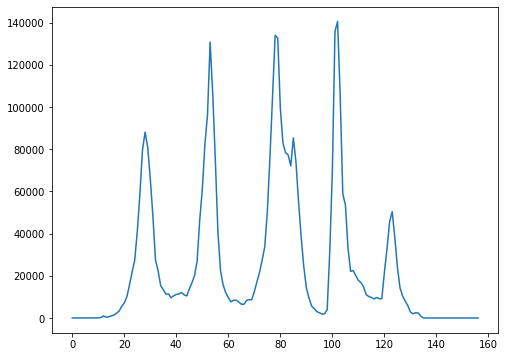

In [64]:
plt.figure(figsize=(8, 6))
covid_data_weekly["daily_cases"].plot()

In [65]:
covid_data_monthly = pd.merge(
    covid_data, calendar_df[["date", "year", "quarter", "month"]], on="date"
)

In [66]:
covid_data_monthly.shape, covid_data_monthly.isnull().sum()

((1096, 6),
 date            0
 daily_cases     0
 daily_deaths    0
 year            0
 quarter         0
 month           0
 dtype: int64)

In [67]:
covid_data_monthly = covid_data_monthly.groupby(
    ["year", "quarter", "month"], as_index=False
).agg({"daily_cases": "sum", "daily_deaths": "sum"})

In [68]:
covid_data_monthly["daily_cases_band"] = pd.qcut(
    covid_data_monthly["daily_cases"],
    q=[0, 0.33, 0.66, 1.0],
    labels=["low", "mid", "high"],
)
covid_data_monthly["daily_deaths_band"] = pd.qcut(
    covid_data_monthly["daily_deaths"],
    q=[0, 0.33, 0.66, 1.0],
    labels=["low", "mid", "high"],
)

<Axes: >

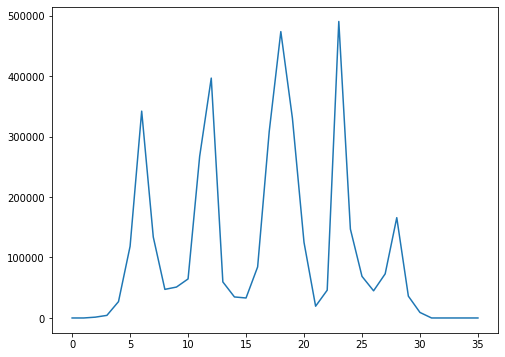

In [69]:
plt.figure(figsize=(8, 6))
covid_data_monthly["daily_cases"].plot()

In [73]:
covid_data_monthly.drop_duplicates(['year','month']).shape

(36, 7)

##### Write out

In [76]:
print(poc_atrb_df.shape, poc_atrb_df.isnull().sum())
print(ppg_atrb_df.shape, ppg_atrb_df.isnull().sum())
print(macro_eco_df_pvt.shape, macro_eco_df_pvt.isnull().sum())
print(ppg_financials.shape, ppg_financials.isnull().sum())
print(calendar_df_week.shape, calendar_df_week.isnull().sum())
print(calendar_df_month.shape, calendar_df_month.isnull().sum())
print(covid_data_weekly.shape, covid_data_weekly.isnull().sum())
print(covid_data_monthly.shape, covid_data_monthly.isnull().sum())
print(weather_data_weekly.shape, weather_data_weekly.isnull().sum())
print(weather_data_monthly.shape, weather_data_monthly.isnull().sum())

(43645, 6) unique_poc_id     0
region            0
subchannel        0
channel_type      0
sales_district    0
segment           0
dtype: int64
(240, 7) ppg_name         0
brand            0
subbrand         0
pack_type        0
pack_volume      0
category_name    0
price_segment    0
dtype: int64
(73, 34) 
date                                                    0
central bank policy rate                                0
consumer price index, aop                               0
consumer price index, aop, usd                          0
effective exchange rate index, nominal                  0
exchange rate lc per eur, aop                           0
exchange rate lc per eur, eop                           0
exchange rate lc per usd, aop                           0
exchange rate lc per usd, eop                           0
exchange rate lc per yen, aop                           0
exchange rate lc per yen, eop                           0
exchange rate usd per lc, aop                        

In [77]:
os.makedirs(os.path.join(os.getcwd(), "macro_processed"), exist_ok=True)

In [78]:
poc_atrb_df.to_pickle(os.path.join(os.getcwd(), "macro_processed", "poc_atrb_df.pkl"))
ppg_atrb_df.to_pickle(os.path.join(os.getcwd(), "macro_processed", "ppg_atrb_df.pkl"))
macro_eco_df_pvt.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "macro_eco_df_pvt.pkl")
)
ppg_financials.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "ppg_financials.pkl")
)
calendar_df_week.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "calendar_df_week.pkl")
)
calendar_df_month.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "calendar_df_month.pkl")
)
covid_data_weekly.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "covid_data_weekly.pkl")
)
covid_data_monthly.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "covid_data_monthly.pkl")
)
weather_data_weekly.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "weather_data_weekly.pkl")
)
weather_data_monthly.to_pickle(
    os.path.join(os.getcwd(), "macro_processed", "weather_data_monthly.pkl")
)